In [6]:
import pandas as pd 
import numpy as np 
import pymc3 as pm 
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import os 
import argparse

from sm_data import generate_prediction_data, generate_NPI_prediction_data, generate_ground_truth_forecast, get_isolation_data_model, get_test_positivity_data_model
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from sm_utils import *
from sm_utils import _get_convolution_ready_gt
from sm_model import SemiMechanisticModels


# Data Imports

In [7]:
DATA_PATH = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
NPI_PATH = 'data/NPIS_LC_processed_V4.csv'

QUARANTINE_DATA_PATH =  '../covid19-modelling-sg/data/statistics/active_number_under_quarantine.csv'
SHN_DATA_PATH = '../covid19-modelling-sg/data/statistics/individuals_under_shn.csv'
TESTS_COUNTS_OWID_PATH = '../Data/owid-covid-data.csv'
TEST_COUNTS_REPO_PATH = '../covid19-modelling-sg/data/statistics/swab_figures.csv'
CASE_BREAKDOWN_PATH = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_split_curve.csv')

In [8]:
# Import parmas
start_id = 50
end_date = 100
prediction_t = 14

val_run = False
separate_dorms = True
separate_quarantine = True

n_chains = 2
tune_steps = 1000
train_steps = 2000
t_accept = 0.99

# IMPORT DATA
community_input, dorm_input, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)

if val_run:
    com_gt, dorm_gt, import_gt, total_gt = generate_ground_truth_forecast(DATA_PATH, start_id=start_id,
                        end_date=end_date, prediction_t=prediction_t)


NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH, start_id=start_id, end_date=end_date, prediction_t=prediction_t)

num_NPIS = NPIS_array.shape[1]
get_isolation_data_model, get_test_positivity_data_model

if separate_quarantine:
    quarantine_stats = get_isolation_data_model(SHN_DATA_PATH, QUARANTINE_DATA_PATH,
                     DATA_PATH, start_id, end_date,
                     shn_start_val=0, prediction_t=prediction_t,
                     quarantine_start_val=0, scale=True,extrapolate_type='ma')

    test_stats = get_test_positivity_data_model(TESTS_COUNTS_OWID_PATH, TEST_COUNTS_REPO_PATH,
                          DATA_PATH, start_id,
                          end_date, prediction_t=prediction_t, start_val=100, scale=True,
                          extrapolate_type='ma')
else:
    quarantine_stats = None
    test_stats = None
    
    
local_cases=community_input
dorm_cases=dorm_input
imported_cases=imported_input
NPIS_array=NPIS_array
len_observed=len_observed
total_cases=None
separate_dorms=separate_dorms
separate_quarantine=separate_quarantine
test_counts=test_stats
quarantine_counts=quarantine_stats
prediction_t=prediction_t
likelihood_fun='PO'

convolution_ready_gt = _get_convolution_ready_gt(len_observed)
delay = pd.read_csv("data/p_delay.csv")
p_delay = np.array(delay)
p_delay[0:6] = [0.0001]

imported cases ma
Length Community training cases:  114   114
Length Dorm training cases:  100
Length into model:  114   114   114
imported cases ma
imported cases ma


# Model

In [68]:
if (test_counts is None) or (quarantine_counts is None):
    raise ValueError('test_counts and quarantine_counts must be input')

if (len(local_cases) != 2) and (not isinstance(local_cases, list)):
    raise ValueError('local_cases should be an list with two elements, Un-quarantined cases series as the first and quarantined cases series as the second')

# Prepare observed data
model_input_local_unquarantined = local_cases[0]
model_input_local_quarantined = local_cases[1]

p_delay_dorm = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_q = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_local = p_delay


with pm.Model() as model_prev:

    # R_t Foreign
    log_r_t_foreign = pm.GaussianRandomWalk(
        'log_r_t_foreign',
        sigma=0.035,
        shape=len_observed)

    # R_t Local
    log_r_t_local = pm.GaussianRandomWalk(
        'log_r_t_local',
        sigma=0.035,
        shape=len_observed)

    if num_NPIS>1:  # Means not using the index thingy
        # NPI Covariates
        beta_list = []
        for i in range(num_NPIS):
            beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
        betas = pm.math.stack(beta_list, 0)
        #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
        rt_covariates = pm.math.dot(np.array(NPIS_array), betas)

    else: # Using index
        beta = pm.Normal(f"b_index", 0, sigma=0.03)
        rt_covariates = beta*np.array(NPIS_array.reshape(-1))

    # Form r_t as GRW + covariates
    r_t_foreign = pm.Deterministic('r_t_foreign', pm.math.exp(log_r_t_foreign + rt_covariates))
    r_t_local = pm.Deterministic('r_t_local', pm.math.exp(log_r_t_local + rt_covariates))

    # Imported leakage
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)

    # Infection Latent Dormitory
    seed_dorm = pm.Exponential('Seed_dorm', 150)  # Scale of infection will be small (Dorm cases started at 0)
    y0_dorm = tt.zeros(len_observed)
    y0_dorm = tt.set_subtensor(y0_dorm[0], seed_dorm)
    # Apply recursively to populate tensor
    outputs_dorm, _ = theano.scan(
            fn=lambda t, gt , y, r_t_foreign: tt.set_subtensor(y[t], tt.sum(r_t_foreign*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0_dorm,
            non_sequences=r_t_foreign,
            n_steps=len_observed-1,
    )
    infections_dorm = pm.Deterministic('infections_dorm', outputs_dorm[-1])

    # Qurantine randomwalk
    log_lambda_t = pm.GaussianRandomWalk(
        'log_lambda_t',
        sigma=0.035,
        shape=len_observed)

    # Beta for no. in quarantine covariate
    beta_quarantine = pm.Normal("beta_quarantine", 0, sigma=0.03)
    quarantine_covariates = beta_quarantine * quarantine_counts

    lambda_t = pm.Deterministic('Q Rate', pm.math.sigmoid(log_lambda_t + quarantine_covariates))


    # Infection Latent Local only
    seed = pm.Exponential('Seed_local', 1)  # Scale of infection will be small (Local cases were quite high already)
    y0_local = tt.zeros(len_observed)
    y0_local = tt.set_subtensor(y0_local[0], seed)
    # Apply recursively to populate tensor
    outputs_local, _ = theano.scan(
            fn=lambda t, gt, i_cases, l_t, y, r_t_local: tt.set_subtensor(y[t], l_t*(tt.sum(r_t_local*y*gt) + eps_t * i_cases)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases), lambda_t],
            outputs_info=y0_local,
            non_sequences=[r_t_local],
            n_steps=len_observed-1,
    )

    infections_local = pm.Deterministic('infections_local_uncontained', outputs_local[-1])
    q_lambda_t = pm.Deterministic('infections_rate', (1-lambda_t)/lambda_t)

    infections_local_contained = pm.Deterministic('infections_local_contained', q_lambda_t*infections_local)

    #### alpha Parameter - determines test rates from 3 sources ####
    # Dorm
    log_alpha_dorm_t = pm.GaussianRandomWalk(
        'log_alpha_dorm_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_unQ_t = pm.GaussianRandomWalk(
        'log_alpha_unQ_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_Q_t = pm.GaussianRandomWalk(
        'log_alpha_Q_t',
        sigma=0.035,
        shape=len_observed)


    # Hierarchical usage of test_counts
    beta_test_hier_mean = pm.Normal("beta_quarantine_hier_mean", 0, sigma=0.03)

    # prior for dorm, local unQ, Q
    # Fixed prior sd of 0.03
    test_dorm_tilde = pm.Normal("test_dorm_tilde", mu=0, sigma=1)
    beta_test_dorm = pm.Deterministic("beta_test_dorm", beta_test_hier_mean + 0.03 * test_dorm_tilde)

    test_unQ_tilde = pm.Normal("test_unQ_tilde", mu=0, sigma=1)
    beta_test_unQ = pm.Deterministic("beta_test_unQ", beta_test_hier_mean + 0.03 * test_unQ_tilde)

    test_Q_tilde = pm.Normal("test_Q_tilde", mu=0, sigma=1)
    beta_test_Q = pm.Deterministic("beta_test_Q", beta_test_hier_mean + 0.03 * test_Q_tilde)

    # Get alphas
    alpha_dorm_t = pm.Deterministic('alpha_dorm_t', pm.math.sigmoid(log_alpha_dorm_t + beta_test_dorm*test_counts))
    alpha_unQ_t = pm.Deterministic('alpha_local_unQ_t', pm.math.sigmoid(log_alpha_unQ_t + beta_test_unQ*test_counts))
    alpha_Q_t = pm.Deterministic('alpha_local_Q_t', pm.math.sigmoid(log_alpha_Q_t + beta_test_Q*test_counts))

    # Onset - Delay Dist - Local
    t_p_delay_local = pm.Data("p_delay_local", p_delay_local)

    # Onset - Delay Dist - Qurantine
    t_p_delay_local_q = pm.Data('p_delay_local_qurantine', p_delay_q)

    # Onset - Delay Dist - Dorm
    t_p_delay_dorm = pm.Data("p_delay_dorm", pd.Series(p_delay_dorm))



    # Test adjusted positive - Local
    test_adjusted_positive_local = pm.Deterministic(
        "test adjusted positive local",
        conv(infections_local, t_p_delay_local, len(p_delay), len_observed)
    )
    test_adjusted_positive_jittered_local = pm.Deterministic('test_adjusted_positive_jit_local',
                                                alpha_unQ_t*test_adjusted_positive_local + 0)


    # Test adjusted positive - Local Qurantined
    test_adjusted_positive_local_qurantined = pm.Deterministic(
        "test adjusted positive local Qurantined",
        conv(infections_local_contained, t_p_delay_local_q, len(p_delay_q), len_observed)
    )
    test_adjusted_positive_jittered_local_qurantined = pm.Deterministic('test_adjusted_positive_jit_local_qurantined',
                                                alpha_Q_t*test_adjusted_positive_local_qurantined + 0)

    # Test adjusted Positive - Dorm
    test_adjusted_positive_dorm = pm.Deterministic(
        "test adjusted positive dorm",
        conv(infections_dorm, t_p_delay_dorm, len(pd.Series(p_delay_dorm)), len_observed)
    )   

    test_adjusted_positive_jittered_dorm = pm.Deterministic('test_adjusted_positive_jit_dorm',
                                                alpha_dorm_t*test_adjusted_positive_dorm + 0)

    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                psi = pm.Beta('psi', 2,2),                    
                observed=local_cases)    

    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                observed=local_cases)

    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs_local', 
                mu=test_adjusted_positive_jittered_local,
                observed=model_input_local_unquarantined)

        pm.Poisson('Obs_local_q', 
                mu=test_adjusted_positive_local_qurantined,
                observed=model_input_local_quarantined)

        pm.Poisson('Obs_dorm', 
                mu=test_adjusted_positive_jittered_dorm,
                observed=dorm_cases)

    trace_prev = pm.sample(
                draws=2000,
                tune=1000,
                chains=2,nuts={'target_accept':t_accept},random_seed=10
            )

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local_q contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `Mult

Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 18 seconds.
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:642: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [74]:
cov.shape

(864, 864)

In [83]:
from pymc3.step_methods.hmc import quadpotential
with model_prev:
    cov = np.atleast_1d(pm.trace_cov(trace_prev))
    start = list(np.random.choice(trace_prev, n_chains))
    #potential = quadpotential.QuadPotentialFull(cov)
    step_size = trace_prev.get_sampler_stats('step_size_bar')[-1]
    
    size = model_prev.bijection.ordering.size
    step_scale = step_size * (size ** 0.25)

In [85]:
cov.shape

(864, 864)

In [86]:
with model_trace_init:
    a = np.atleast_1d(pm.trace_cov(trace_no_prior))

In [87]:
a.shape

(864, 864)

In [76]:
trace_no_prior

<MultiTrace: 2 chains, 20 iterations, 49 variables>

# Online

In [14]:
from copy import deepcopy

In [15]:
trace_prev_save = deepcopy(trace_prev)
print(trace_prev['b_0'].shape)

(40,)


## Update Trace Object to take in new stuff

In [238]:
def mod_vals(trace, varname, concat_len, mod_trace=False):
    
    if mod_trace:
        trace_in = trace
    else:
        trace_in = deepcopy(trace)

    # Get latest value
    latest_val = trace_in[varname][:,-1]
    
    # Create array to append
    addition_vals = np.tile(latest_val,(concat_len,1)).T
    padded_samples = np.concatenate([trace_in[varname], addition_vals], 1)
    
    # Modify trace object
    trace_in.add_values({varname: padded_samples}, overwrite=True)
    
    return trace_in

In [298]:
trace_prev_mod = deepcopy(trace_prev)

In [299]:
ts_vars = [x for x in trace_prev_mod.varnames if len(trace_prev_mod[x].shape) == 2]
ts_vars

skip_vars =  ['Obs_local_missing','Obs_local_q_missing','Obs_dorm_missing']

In [300]:
[(x,trace_prev[x].shape) for x in trace_prev_mod.varnames]

[('log_r_t_foreign', (10, 114)),
 ('log_r_t_local', (10, 114)),
 ('b_0', (10,)),
 ('b_1', (10,)),
 ('b_2', (10,)),
 ('b_3', (10,)),
 ('b_4', (10,)),
 ('b_5', (10,)),
 ('b_6', (10,)),
 ('b_7', (10,)),
 ('b_8', (10,)),
 ('b_9', (10,)),
 ('eps_t_logodds__', (10,)),
 ('Seed_dorm_log__', (10,)),
 ('log_lambda_t', (10, 114)),
 ('beta_quarantine', (10,)),
 ('Seed_local_log__', (10,)),
 ('log_alpha_dorm_t', (10, 114)),
 ('log_alpha_unQ_t', (10, 114)),
 ('log_alpha_Q_t', (10, 114)),
 ('beta_quarantine_hier_mean', (10,)),
 ('test_dorm_tilde', (10,)),
 ('test_unQ_tilde', (10,)),
 ('test_Q_tilde', (10,)),
 ('Obs_local_missing', (10, 14)),
 ('Obs_local_q_missing', (10, 14)),
 ('Obs_dorm_missing', (10, 14)),
 ('r_t_foreign', (10, 114)),
 ('r_t_local', (10, 114)),
 ('eps_t', (10,)),
 ('Seed_dorm', (10,)),
 ('infections_dorm', (10, 114)),
 ('Q Rate', (10, 114)),
 ('Seed_local', (10,)),
 ('infections_local_uncontained', (10, 114)),
 ('infections_rate', (10, 114)),
 ('infections_local_contained', (10, 1

In [ ]:
trace_prev.

In [301]:
# Modify trace values
for t_var in ts_vars:
    if t_var in skip_vars:
        continue
    mod_vals(trace_prev_mod, t_var, concat_len=20, mod_trace=True)
    
    # Modify trace shape
    for k in trace_prev_mod._straces.keys():
        trace_prev_mod._straces[k].var_shapes[t_var] = (134,)

Create Starting Point Based on Previous
- For Scalar Values: Take Mean
- For TS Values: Take Mean and Extrapolate Last Value

In [44]:
def mod_vals(samples, concat_len):

    # Get latest value
    latest_val = samples[:,-1]
    
    # Create array to append
    addition_vals = np.tile(latest_val,(concat_len,1)).T
    padded_samples = np.concatenate([samples, addition_vals], 1)
    
    # Modify trace object
    out_val = padded_samples.mean(0)
    
    return out_val

In [45]:
vars_need_init = [
 'log_r_t_foreign',
 'log_r_t_local',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',  
 'eps_t',
 'Seed_dorm',
 'log_lambda_t',
 'beta_quarantine',
 'Seed_local',
 'beta_quarantine_hier_mean',
 'test_dorm_tilde',
 'test_unQ_tilde',
 'test_Q_tilde',
 'log_alpha_dorm_t',
 'log_alpha_unQ_t',
 'log_alpha_Q_t',
]

In [65]:
def generate_start_values(vars_need_init, trace_prev, len_prev_use, new_len_wanted):
    
    add_len_needed = new_len_wanted - len_prev_use
    
    start_vals = {}
    for var in vars_need_init:

        samples = trace_prev[var]

        if len(samples.shape)==1 :  # 1d variable
            sample_mean = samples.mean()

        else:
            samples = samples[:,:len_prev_use]
            sample_mean = mod_vals(samples, add_len_needed)

        start_vals[var] = sample_mean
    
    return start_vals

# New Model

# Data Import (with longer data)

In [62]:
# Import parmas
start_id = 50
end_date = 120
prediction_t = 14

val_run = False
separate_dorms = True
separate_quarantine = True

n_chains = 2
tune_steps = 10
train_steps = 100
t_accept = 0.99

# IMPORT DATA
community_input, dorm_input, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)

if val_run:
    com_gt, dorm_gt, import_gt, total_gt = generate_ground_truth_forecast(DATA_PATH, start_id=start_id,
                        end_date=end_date, prediction_t=prediction_t)


NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH, start_id=start_id, end_date=end_date, prediction_t=prediction_t)

num_NPIS = NPIS_array.shape[1]
get_isolation_data_model, get_test_positivity_data_model

if separate_quarantine:
    quarantine_stats = get_isolation_data_model(SHN_DATA_PATH, QUARANTINE_DATA_PATH,
                     DATA_PATH, start_id, end_date,
                     shn_start_val=0, prediction_t=prediction_t,
                     quarantine_start_val=0, scale=True,extrapolate_type='ma')

    test_stats = get_test_positivity_data_model(TESTS_COUNTS_OWID_PATH, TEST_COUNTS_REPO_PATH,
                          DATA_PATH, start_id,
                          end_date, prediction_t=prediction_t, start_val=100, scale=True,
                          extrapolate_type='ma')
else:
    quarantine_stats = None
    test_stats = None
    
    
local_cases=community_input
dorm_cases=dorm_input
imported_cases=imported_input
NPIS_array=NPIS_array
len_observed=len_observed
total_cases=None
separate_dorms=separate_dorms
separate_quarantine=separate_quarantine
test_counts=test_stats
quarantine_counts=quarantine_stats
prediction_t=prediction_t
likelihood_fun='PO'

convolution_ready_gt = _get_convolution_ready_gt(len_observed)
delay = pd.read_csv("data/p_delay.csv")
p_delay = np.array(delay)
p_delay[0:6] = [0.0001]

imported cases ma
Length Community training cases:  134   134
Length Dorm training cases:  120
Length into model:  134   134   134
imported cases ma
imported cases ma


# Online learning via Trace Initialization

In [63]:
len_prev = trace_prev['log_r_t_local'].shape[-1]
len_prev_predict = trace_prev['Obs_local_q_missing'].shape[-1]
len_prev_wanted = len_prev - len_prev_predict

len_new_required = len_observed - len_prev_wanted

In [66]:
start_values_trace = generate_start_values(vars_need_init,
                                           trace_prev=trace_prev,
                                           len_prev_use=100,
                                           new_len_wanted=134)

In [78]:
if (test_counts is None) or (quarantine_counts is None):
    raise ValueError('test_counts and quarantine_counts must be input')

if (len(local_cases) != 2) and (not isinstance(local_cases, list)):
    raise ValueError('local_cases should be an list with two elements, Un-quarantined cases series as the first and quarantined cases series as the second')

# Prepare observed data
model_input_local_unquarantined = local_cases[0]
model_input_local_quarantined = local_cases[1]

p_delay_dorm = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_q = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_local = p_delay


with pm.Model() as model_trace_init:

    # R_t Foreign
    log_r_t_foreign = pm.GaussianRandomWalk(
        'log_r_t_foreign',
        sigma=0.035,
        shape=len_observed)

    # R_t Local
    log_r_t_local = pm.GaussianRandomWalk(
        'log_r_t_local',
        sigma=0.035,
        shape=len_observed)

    if num_NPIS>1:  # Means not using the index thingy
        # NPI Covariates
        beta_list = []
        for i in range(num_NPIS):
            beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
        betas = pm.math.stack(beta_list, 0)
        #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
        rt_covariates = pm.math.dot(np.array(NPIS_array), betas)

    else: # Using index
        beta = pm.Normal(f"b_index", 0, sigma=0.03)
        rt_covariates = beta*np.array(NPIS_array.reshape(-1))

    # Form r_t as GRW + covariates
    r_t_foreign = pm.Deterministic('r_t_foreign', pm.math.exp(log_r_t_foreign + rt_covariates))
    r_t_local = pm.Deterministic('r_t_local', pm.math.exp(log_r_t_local + rt_covariates))

    # Imported leakage
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)

    # Infection Latent Dormitory
    seed_dorm = pm.Exponential('Seed_dorm', 150)  # Scale of infection will be small (Dorm cases started at 0)
    y0_dorm = tt.zeros(len_observed)
    y0_dorm = tt.set_subtensor(y0_dorm[0], seed_dorm)
    # Apply recursively to populate tensor
    outputs_dorm, _ = theano.scan(
            fn=lambda t, gt , y, r_t_foreign: tt.set_subtensor(y[t], tt.sum(r_t_foreign*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0_dorm,
            non_sequences=r_t_foreign,
            n_steps=len_observed-1,
    )
    infections_dorm = pm.Deterministic('infections_dorm', outputs_dorm[-1])

    # Qurantine randomwalk
    log_lambda_t = pm.GaussianRandomWalk(
        'log_lambda_t',
        sigma=0.035,
        shape=len_observed)

    # Beta for no. in quarantine covariate
    beta_quarantine = pm.Normal("beta_quarantine", 0, sigma=0.03)
    quarantine_covariates = beta_quarantine * quarantine_counts

    lambda_t = pm.Deterministic('Q Rate', pm.math.sigmoid(log_lambda_t + quarantine_covariates))


    # Infection Latent Local only
    seed = pm.Exponential('Seed_local', 1)  # Scale of infection will be small (Local cases were quite high already)
    y0_local = tt.zeros(len_observed)
    y0_local = tt.set_subtensor(y0_local[0], seed)
    # Apply recursively to populate tensor
    outputs_local, _ = theano.scan(
            fn=lambda t, gt, i_cases, l_t, y, r_t_local: tt.set_subtensor(y[t], l_t*(tt.sum(r_t_local*y*gt) + eps_t * i_cases)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases), lambda_t],
            outputs_info=y0_local,
            non_sequences=[r_t_local],
            n_steps=len_observed-1,
    )

    infections_local = pm.Deterministic('infections_local_uncontained', outputs_local[-1])
    q_lambda_t = pm.Deterministic('infections_rate', (1-lambda_t)/lambda_t)

    infections_local_contained = pm.Deterministic('infections_local_contained', q_lambda_t*infections_local)

    #### alpha Parameter - determines test rates from 3 sources ####
    # Dorm
    log_alpha_dorm_t = pm.GaussianRandomWalk(
        'log_alpha_dorm_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_unQ_t = pm.GaussianRandomWalk(
        'log_alpha_unQ_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_Q_t = pm.GaussianRandomWalk(
        'log_alpha_Q_t',
        sigma=0.035,
        shape=len_observed)


    # Hierarchical usage of test_counts
    beta_test_hier_mean = pm.Normal("beta_quarantine_hier_mean", 0, sigma=0.03)

    # prior for dorm, local unQ, Q
    # Fixed prior sd of 0.03
    test_dorm_tilde = pm.Normal("test_dorm_tilde", mu=0, sigma=1)
    beta_test_dorm = pm.Deterministic("beta_test_dorm", beta_test_hier_mean + 0.03 * test_dorm_tilde)

    test_unQ_tilde = pm.Normal("test_unQ_tilde", mu=0, sigma=1)
    beta_test_unQ = pm.Deterministic("beta_test_unQ", beta_test_hier_mean + 0.03 * test_unQ_tilde)

    test_Q_tilde = pm.Normal("test_Q_tilde", mu=0, sigma=1)
    beta_test_Q = pm.Deterministic("beta_test_Q", beta_test_hier_mean + 0.03 * test_Q_tilde)

    # Get alphas
    alpha_dorm_t = pm.Deterministic('alpha_dorm_t', pm.math.sigmoid(log_alpha_dorm_t + beta_test_dorm*test_counts))
    alpha_unQ_t = pm.Deterministic('alpha_local_unQ_t', pm.math.sigmoid(log_alpha_unQ_t + beta_test_unQ*test_counts))
    alpha_Q_t = pm.Deterministic('alpha_local_Q_t', pm.math.sigmoid(log_alpha_Q_t + beta_test_Q*test_counts))

    # Onset - Delay Dist - Local
    t_p_delay_local = pm.Data("p_delay_local", p_delay_local)

    # Onset - Delay Dist - Qurantine
    t_p_delay_local_q = pm.Data('p_delay_local_qurantine', p_delay_q)

    # Onset - Delay Dist - Dorm
    t_p_delay_dorm = pm.Data("p_delay_dorm", pd.Series(p_delay_dorm))



    # Test adjusted positive - Local
    test_adjusted_positive_local = pm.Deterministic(
        "test adjusted positive local",
        conv(infections_local, t_p_delay_local, len(p_delay), len_observed)
    )
    test_adjusted_positive_jittered_local = pm.Deterministic('test_adjusted_positive_jit_local',
                                                alpha_unQ_t*test_adjusted_positive_local + 0)


    # Test adjusted positive - Local Qurantined
    test_adjusted_positive_local_qurantined = pm.Deterministic(
        "test adjusted positive local Qurantined",
        conv(infections_local_contained, t_p_delay_local_q, len(p_delay_q), len_observed)
    )
    test_adjusted_positive_jittered_local_qurantined = pm.Deterministic('test_adjusted_positive_jit_local_qurantined',
                                                alpha_Q_t*test_adjusted_positive_local_qurantined + 0)

    # Test adjusted Positive - Dorm
    test_adjusted_positive_dorm = pm.Deterministic(
        "test adjusted positive dorm",
        conv(infections_dorm, t_p_delay_dorm, len(pd.Series(p_delay_dorm)), len_observed)
    )   

    test_adjusted_positive_jittered_dorm = pm.Deterministic('test_adjusted_positive_jit_dorm',
                                                alpha_dorm_t*test_adjusted_positive_dorm + 0)

    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                psi = pm.Beta('psi', 2,2),                    
                observed=local_cases)    

    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                observed=local_cases)

    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs_local', 
                mu=test_adjusted_positive_jittered_local,
                observed=model_input_local_unquarantined)

        pm.Poisson('Obs_local_q', 
                mu=test_adjusted_positive_local_qurantined,
                observed=model_input_local_quarantined)

        pm.Poisson('Obs_dorm', 
                mu=test_adjusted_positive_jittered_dorm,
                observed=dorm_cases)

    trace_no_prior = pm.sample(
                draws=20,
                tune=10,
                chains=2,nuts={'target_accept':t_accept},random_seed=10,
                start=start_values_trace
            )

hi


Only 20 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [test_Q_tilde, test_unQ_tilde, test_dorm_tilde, beta_quarantine_hier_mean, log_alpha_Q_t, log_alpha_unQ_t, log_alpha_dorm_t, Seed_local, beta_quarantine, log_lambda_t, Seed_dorm, eps_t, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0, log_r_t_local, log_r_t_foreign]
>CompoundStep
>>Metropolis: [Obs_dorm_missing]
>>Metropolis: [Obs_local_q_missing]
>>Metropolis: [Obs_local_missing]


Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 76 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [59]:
start_values_trace['log_r_t_foreign'].shape

(148,)

In [499]:
if (test_counts is None) or (quarantine_counts is None):
    raise ValueError('test_counts and quarantine_counts must be input')

if (len(local_cases) != 2) and (not isinstance(local_cases, list)):
    raise ValueError('local_cases should be an list with two elements, Un-quarantined cases series as the first and quarantined cases series as the second')

# Prepare observed data
model_input_local_unquarantined = local_cases[0]
model_input_local_quarantined = local_cases[1]

p_delay_dorm = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_q = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])
p_delay_local = p_delay


with pm.Model() as model_unInf_prior:

    # R_t Foreign
    log_r_t_foreign = pm.GaussianRandomWalk(
        'log_r_t_foreign',
        sigma=0.035,
        shape=len_observed)

    # R_t Local
    log_r_t_local = pm.GaussianRandomWalk(
        'log_r_t_local',
        sigma=0.035,
        shape=len_observed)

    if num_NPIS>1:  # Means not using the index thingy
        # NPI Covariates
        beta_list = []
        for i in range(num_NPIS):
            beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
        betas = pm.math.stack(beta_list, 0)
        #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
        rt_covariates = pm.math.dot(np.array(NPIS_array), betas)

    else: # Using index
        beta = pm.Normal(f"b_index", 0, sigma=0.03)
        rt_covariates = beta*np.array(NPIS_array.reshape(-1))

    # Form r_t as GRW + covariates
    r_t_foreign = pm.Deterministic('r_t_foreign', pm.math.exp(log_r_t_foreign + rt_covariates))
    r_t_local = pm.Deterministic('r_t_local', pm.math.exp(log_r_t_local + rt_covariates))

    # Imported leakage
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)

    # Infection Latent Dormitory
    seed_dorm = pm.Exponential('Seed_dorm', 150)  # Scale of infection will be small (Dorm cases started at 0)
    y0_dorm = tt.zeros(len_observed)
    y0_dorm = tt.set_subtensor(y0_dorm[0], seed_dorm)
    # Apply recursively to populate tensor
    outputs_dorm, _ = theano.scan(
            fn=lambda t, gt , y, r_t_foreign: tt.set_subtensor(y[t], tt.sum(r_t_foreign*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0_dorm,
            non_sequences=r_t_foreign,
            n_steps=len_observed-1,
    )
    infections_dorm = pm.Deterministic('infections_dorm', outputs_dorm[-1])

    # Qurantine randomwalk
    log_lambda_t = pm.GaussianRandomWalk(
        'log_lambda_t',
        sigma=0.035,
        shape=len_observed)

    # Beta for no. in quarantine covariate
    beta_quarantine = pm.Normal("beta_quarantine", 0, sigma=0.03)
    quarantine_covariates = beta_quarantine * quarantine_counts

    lambda_t = pm.Deterministic('Q Rate', pm.math.sigmoid(log_lambda_t + quarantine_covariates))


    # Infection Latent Local only
    seed = pm.Exponential('Seed_local', 1)  # Scale of infection will be small (Local cases were quite high already)
    y0_local = tt.zeros(len_observed)
    y0_local = tt.set_subtensor(y0_local[0], seed)
    # Apply recursively to populate tensor
    outputs_local, _ = theano.scan(
            fn=lambda t, gt, i_cases, l_t, y, r_t_local: tt.set_subtensor(y[t], l_t*(tt.sum(r_t_local*y*gt) + eps_t * i_cases)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases), lambda_t],
            outputs_info=y0_local,
            non_sequences=[r_t_local],
            n_steps=len_observed-1,
    )

    infections_local = pm.Deterministic('infections_local_uncontained', outputs_local[-1])
    q_lambda_t = pm.Deterministic('infections_rate', (1-lambda_t)/lambda_t)

    infections_local_contained = pm.Deterministic('infections_local_contained', q_lambda_t*infections_local)

    #### alpha Parameter - determines test rates from 3 sources ####
    # Dorm
    log_alpha_dorm_t = pm.GaussianRandomWalk(
        'log_alpha_dorm_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_unQ_t = pm.GaussianRandomWalk(
        'log_alpha_unQ_t',
        sigma=0.035,
        shape=len_observed)

    # Local - UnQ
    log_alpha_Q_t = pm.GaussianRandomWalk(
        'log_alpha_Q_t',
        sigma=0.035,
        shape=len_observed)


    # Hierarchical usage of test_counts
    beta_test_hier_mean = pm.Normal("beta_quarantine_hier_mean", 0, sigma=0.03)

    # prior for dorm, local unQ, Q
    # Fixed prior sd of 0.03
    test_dorm_tilde = pm.Normal("test_dorm_tilde", mu=0, sigma=1)
    beta_test_dorm = pm.Deterministic("beta_test_dorm", beta_test_hier_mean + 0.03 * test_dorm_tilde)

    test_unQ_tilde = pm.Normal("test_unQ_tilde", mu=0, sigma=1)
    beta_test_unQ = pm.Deterministic("beta_test_unQ", beta_test_hier_mean + 0.03 * test_unQ_tilde)

    test_Q_tilde = pm.Normal("test_Q_tilde", mu=0, sigma=1)
    beta_test_Q = pm.Deterministic("beta_test_Q", beta_test_hier_mean + 0.03 * test_Q_tilde)

    # Get alphas
    alpha_dorm_t = pm.Deterministic('alpha_dorm_t', pm.math.sigmoid(log_alpha_dorm_t + beta_test_dorm*test_counts))
    alpha_unQ_t = pm.Deterministic('alpha_local_unQ_t', pm.math.sigmoid(log_alpha_unQ_t + beta_test_unQ*test_counts))
    alpha_Q_t = pm.Deterministic('alpha_local_Q_t', pm.math.sigmoid(log_alpha_Q_t + beta_test_Q*test_counts))

    # Onset - Delay Dist - Local
    t_p_delay_local = pm.Data("p_delay_local", p_delay_local)

    # Onset - Delay Dist - Qurantine
    t_p_delay_local_q = pm.Data('p_delay_local_qurantine', p_delay_q)

    # Onset - Delay Dist - Dorm
    t_p_delay_dorm = pm.Data("p_delay_dorm", pd.Series(p_delay_dorm))



    # Test adjusted positive - Local
    test_adjusted_positive_local = pm.Deterministic(
        "test adjusted positive local",
        conv(infections_local, t_p_delay_local, len(p_delay), len_observed)
    )
    test_adjusted_positive_jittered_local = pm.Deterministic('test_adjusted_positive_jit_local',
                                                alpha_unQ_t*test_adjusted_positive_local + 0)


    # Test adjusted positive - Local Qurantined
    test_adjusted_positive_local_qurantined = pm.Deterministic(
        "test adjusted positive local Qurantined",
        conv(infections_local_contained, t_p_delay_local_q, len(p_delay_q), len_observed)
    )
    test_adjusted_positive_jittered_local_qurantined = pm.Deterministic('test_adjusted_positive_jit_local_qurantined',
                                                alpha_Q_t*test_adjusted_positive_local_qurantined + 0)

    # Test adjusted Positive - Dorm
    test_adjusted_positive_dorm = pm.Deterministic(
        "test adjusted positive dorm",
        conv(infections_dorm, t_p_delay_dorm, len(pd.Series(p_delay_dorm)), len_observed)
    )   

    test_adjusted_positive_jittered_dorm = pm.Deterministic('test_adjusted_positive_jit_dorm',
                                                alpha_dorm_t*test_adjusted_positive_dorm + 0)

    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                psi = pm.Beta('psi', 2,2),                    
                observed=local_cases)    

    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                mu=test_adjusted_positive_jittered, 
                alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                observed=local_cases)

    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs_local', 
                mu=test_adjusted_positive_jittered_local,
                observed=model_input_local_unquarantined)

        pm.Poisson('Obs_local_q', 
                mu=test_adjusted_positive_local_qurantined,
                observed=model_input_local_quarantined)

        pm.Poisson('Obs_dorm', 
                mu=test_adjusted_positive_jittered_dorm,
                observed=dorm_cases)

    trace_no_prior = pm.sample(
                draws=1500,
                tune=1000,
                chains=2,nuts={'target_accept':t_accept},random_seed=10
            )

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local_q contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `Mult

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 9591 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Comparing 3 three traces
- Trace trained on initial -> 'Prior'
- Trace with prior distributions (roughly) set as posterior of trace 1
- Trace with non informative prior distributions
- Trace 2 and 3 both 1000 tune, 1500 draws and 2 chains

## Training Time
- Online: 3hr 29mins
- Not online: 2hr 39min

### Checking Convergence

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Text(0.5, 1.0, 'No Info')

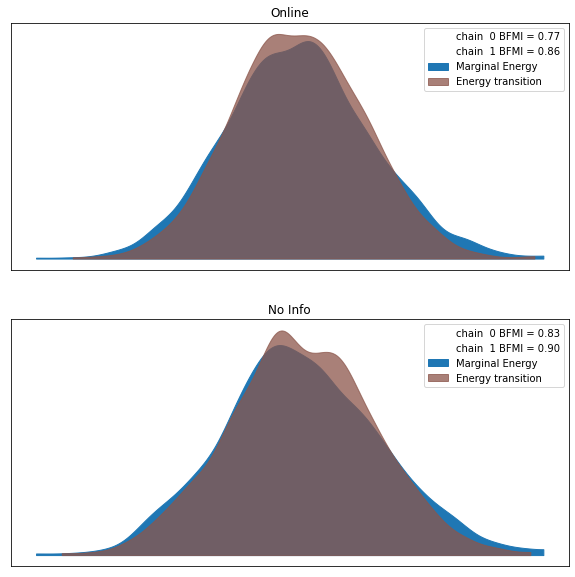

In [500]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
az.plot_energy(trace_new, ax=ax[0])
az.plot_energy(trace_no_prior, ax=ax[1])
ax[0].set_title('Online')
ax[1].set_title('No Info')
plt.show()

### Checking Prior Distributions

### Checking posterior on values

Latent R(t)

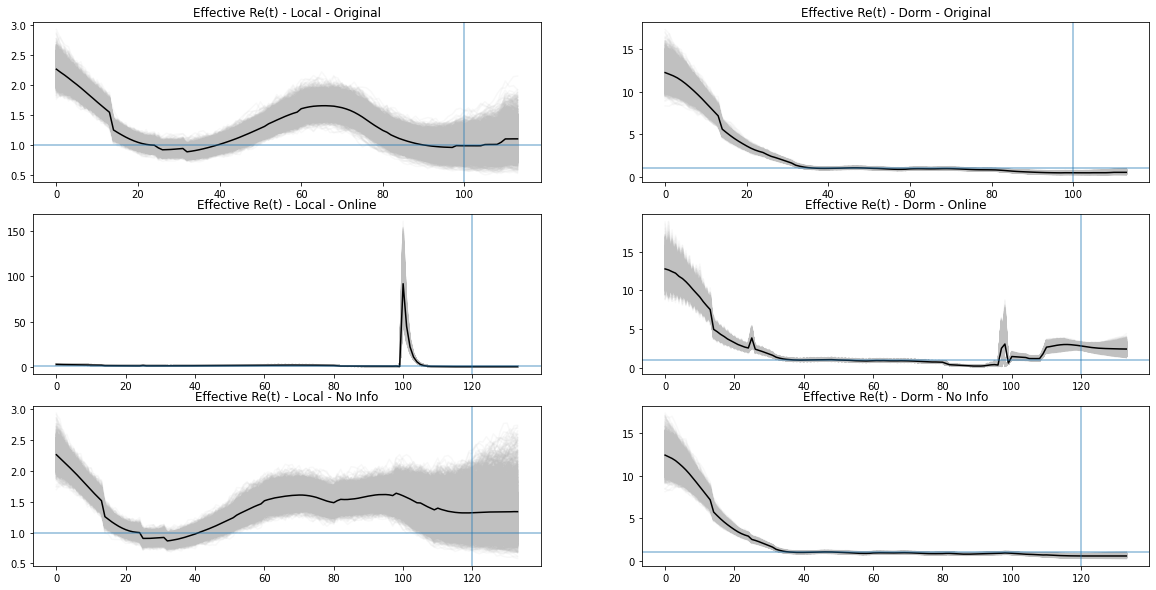

In [507]:
fig, ax = plt.subplots(3,2, figsize=(20,10))

trace1 = trace_new
trace2 = trace_no_prior
end_date = 120


ax[0,0].plot(trace_prev['r_t_local'].T, c='silver', alpha=0.1)
ax[0,0].plot(trace_prev['r_t_local'].mean(0), c='black', alpha=1)
ax[0,0].axhline(y=1, alpha=0.5)
ax[0,0].axvline(x=100, alpha=0.5)
ax[0,0].set_title("Effective Re(t) - Local - Original")

ax[0,1].plot(trace_prev['r_t_foreign'].T, c='silver', alpha=0.1)
ax[0,1].plot(trace_prev['r_t_foreign'].mean(0), c='black', alpha=1)
ax[0,1].axhline(y=1, alpha=0.5)
ax[0,1].axvline(x=100, alpha=0.5)
ax[0,1].set_title("Effective Re(t) - Dorm - Original")

ax[1,0].plot(trace1['r_t_local'].T, c='silver', alpha=0.1)
ax[1,0].plot(trace1['r_t_local'].mean(0), c='black', alpha=1)
ax[1,0].axhline(y=1, alpha=0.5)
ax[1,0].axvline(x=end_date, alpha=0.5)
ax[1,0].set_title("Effective Re(t) - Local - Online")

ax[1,1].plot(trace1['r_t_foreign'].T, c='silver', alpha=0.1)
ax[1,1].plot(trace1['r_t_foreign'].mean(0), c='black', alpha=1)
ax[1,1].axhline(y=1, alpha=0.5)
ax[1,1].axvline(x=end_date, alpha=0.5)
ax[1,1].set_title("Effective Re(t) - Dorm - Online")

ax[2,0].plot(trace2['r_t_local'].T, c='silver', alpha=0.1)
ax[2,0].plot(trace2['r_t_local'].mean(0), c='black', alpha=1)
ax[2,0].axhline(y=1, alpha=0.5)
ax[2,0].axvline(x=end_date, alpha=0.5)
ax[2,0].set_title("Effective Re(t) - Local - No Info")

ax[2,1].plot(trace2['r_t_foreign'].T, c='silver', alpha=0.1)
ax[2,1].plot(trace2['r_t_foreign'].mean(0), c='black', alpha=1)
ax[2,1].axhline(y=1, alpha=0.5)
ax[2,1].axvline(x=end_date, alpha=0.5)
ax[2,1].set_title("Effective Re(t) - Dorm - No Info")

plt.show()

Quarantine Rate

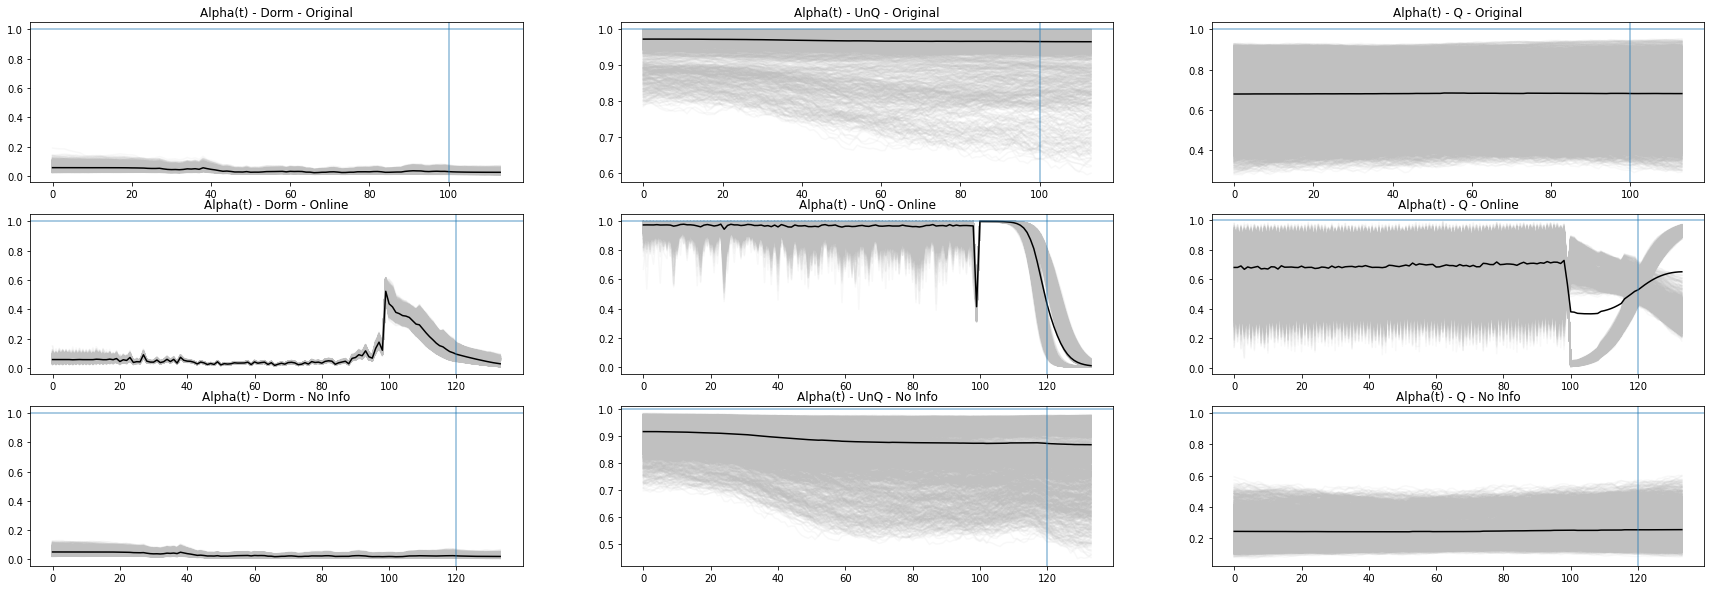

In [511]:
fig, ax = plt.subplots(3,3, figsize=(30,10))

ax[0,0].plot(trace_prev['alpha_dorm_t'].T, c='silver', alpha=0.1)
ax[0,0].plot(trace_prev['alpha_dorm_t'].mean(0), c='black', alpha=1)
ax[0,0].axhline(y=1, alpha=0.5)
ax[0,0].axvline(x=100, alpha=0.5)
ax[0,0].set_title('Alpha(t) - Dorm - Original')

ax[0,1].plot(trace_prev['alpha_local_unQ_t'].T, c='silver', alpha=0.1)
ax[0,1].plot(trace_prev['alpha_local_unQ_t'].mean(0), c='black', alpha=1)
ax[0,1].axhline(y=1, alpha=0.5)
ax[0,1].axvline(x=100, alpha=0.5)
ax[0,1].set_title('Alpha(t) - UnQ - Original')

ax[0,2].plot(trace_prev['alpha_local_Q_t'].T, c='silver', alpha=0.1)
ax[0,2].plot(trace_prev['alpha_local_Q_t'].mean(0), c='black', alpha=1)
ax[0,2].axhline(y=1, alpha=0.5)
ax[0,2].axvline(x=100, alpha=0.5)
ax[0,2].set_title('Alpha(t) - Q - Original')

ax[1,0].plot(trace1['alpha_dorm_t'].T, c='silver', alpha=0.1)
ax[1,0].plot(trace1['alpha_dorm_t'].mean(0), c='black', alpha=1)
ax[1,0].axhline(y=1, alpha=0.5)
ax[1,0].axvline(x=end_date, alpha=0.5)
ax[1,0].set_title('Alpha(t) - Dorm - Online')

ax[1,1].plot(trace1['alpha_local_unQ_t'].T, c='silver', alpha=0.1)
ax[1,1].plot(trace1['alpha_local_unQ_t'].mean(0), c='black', alpha=1)
ax[1,1].axhline(y=1, alpha=0.5)
ax[1,1].axvline(x=end_date, alpha=0.5)
ax[1,1].set_title('Alpha(t) - UnQ - Online')

ax[1,2].plot(trace1['alpha_local_Q_t'].T, c='silver', alpha=0.1)
ax[1,2].plot(trace1['alpha_local_Q_t'].mean(0), c='black', alpha=1)
ax[1,2].axhline(y=1, alpha=0.5)
ax[1,2].axvline(x=end_date, alpha=0.5)
ax[1,2].set_title('Alpha(t) - Q - Online')

ax[2,0].plot(trace2['alpha_dorm_t'].T, c='silver', alpha=0.1)
ax[2,0].plot(trace2['alpha_dorm_t'].mean(0), c='black', alpha=1)
ax[2,0].axhline(y=1, alpha=0.5)
ax[2,0].axvline(x=end_date, alpha=0.5)
ax[2,0].set_title('Alpha(t) - Dorm - No Info')

ax[2,1].plot(trace2['alpha_local_unQ_t'].T, c='silver', alpha=0.1)
ax[2,1].plot(trace2['alpha_local_unQ_t'].mean(0), c='black', alpha=1)
ax[2,1].axhline(y=1, alpha=0.5)
ax[2,1].axvline(x=end_date, alpha=0.5)
ax[2,1].set_title('Alpha(t) - UnQ - No Info')

ax[2,2].plot(trace2['alpha_local_Q_t'].T, c='silver', alpha=0.1)
ax[2,2].plot(trace2['alpha_local_Q_t'].mean(0), c='black', alpha=1)
ax[2,2].axhline(y=1, alpha=0.5)
ax[2,2].axvline(x=end_date, alpha=0.5)
ax[2,2].set_title('Alpha(t) - Q - No Information')

plt.show()

Quarantine Rate

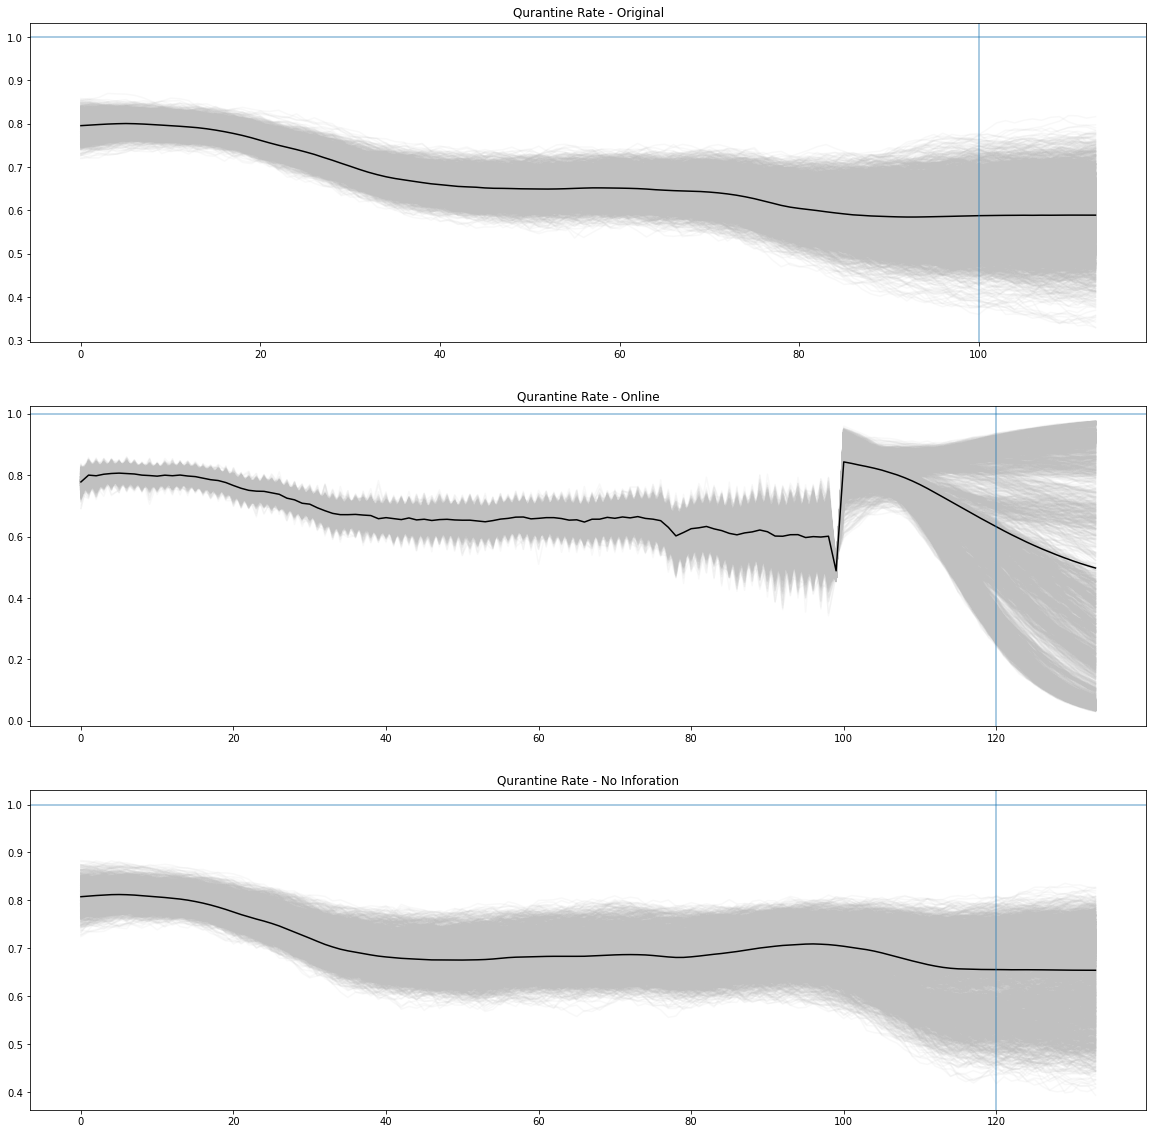

In [515]:
fig, ax = plt.subplots(3,1,figsize=(20,20))

ax[0].plot(trace_prev['Q Rate'].T, c='silver', alpha=0.1)
ax[0].plot(trace_prev['Q Rate'].mean(0), c='black', alpha=1)
ax[0].axhline(y=1, alpha=0.5)
ax[0].axvline(x=100, alpha=0.5)
ax[0].set_title('Qurantine Rate - Original')

ax[1].plot(trace1['Q Rate'].T, c='silver', alpha=0.1)
ax[1].plot(trace1['Q Rate'].mean(0), c='black', alpha=1)
ax[1].axhline(y=1, alpha=0.5)
ax[1].axvline(x=end_date, alpha=0.5)
ax[1].set_title('Qurantine Rate - Online')

ax[2].plot(trace2['Q Rate'].T, c='silver', alpha=0.1)
ax[2].plot(trace2['Q Rate'].mean(0), c='black', alpha=1)
ax[2].axhline(y=1, alpha=0.5)
ax[2].axvline(x=end_date, alpha=0.5)
ax[2].set_title('Qurantine Rate - No Information')
plt.show()

Latents

In [537]:

# Import parmas
start_id = 50
end_date = 100
prediction_t = 14

val_run = False
separate_dorms = True
separate_quarantine = True

n_chains = 2
tune_steps = 1000
train_steps = 2000
t_accept = 0.99

# IMPORT DATA
local_cases1, dorm_cases1, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)

# Import parmas
start_id = 50
end_date = 120
prediction_t = 14

val_run = False
separate_dorms = True
separate_quarantine = True

n_chains = 2
tune_steps = 10
train_steps = 100
t_accept = 0.99

# IMPORT DATA
local_cases2, dorm_cases2, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)


# Get actual 
end_date = 134
all_cases_local, all_dorms, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)

imported cases ma
Length Community training cases:  114   114
Length Dorm training cases:  100
Length into model:  114   114   114
imported cases ma
Length Community training cases:  134   134
Length Dorm training cases:  120
Length into model:  134   134   134
imported cases ma
Length Community training cases:  148   148
Length Dorm training cases:  134
Length into model:  148   148   148


In [548]:
all_cases_local1 = [x[0:114] for x in all_cases_local]
all_cases_local2 = [x[0:134] for x in all_cases_local]

all_dorm_cases1 = all_dorms[0:114]
all_dorm_cases2 = all_dorms[0:134]

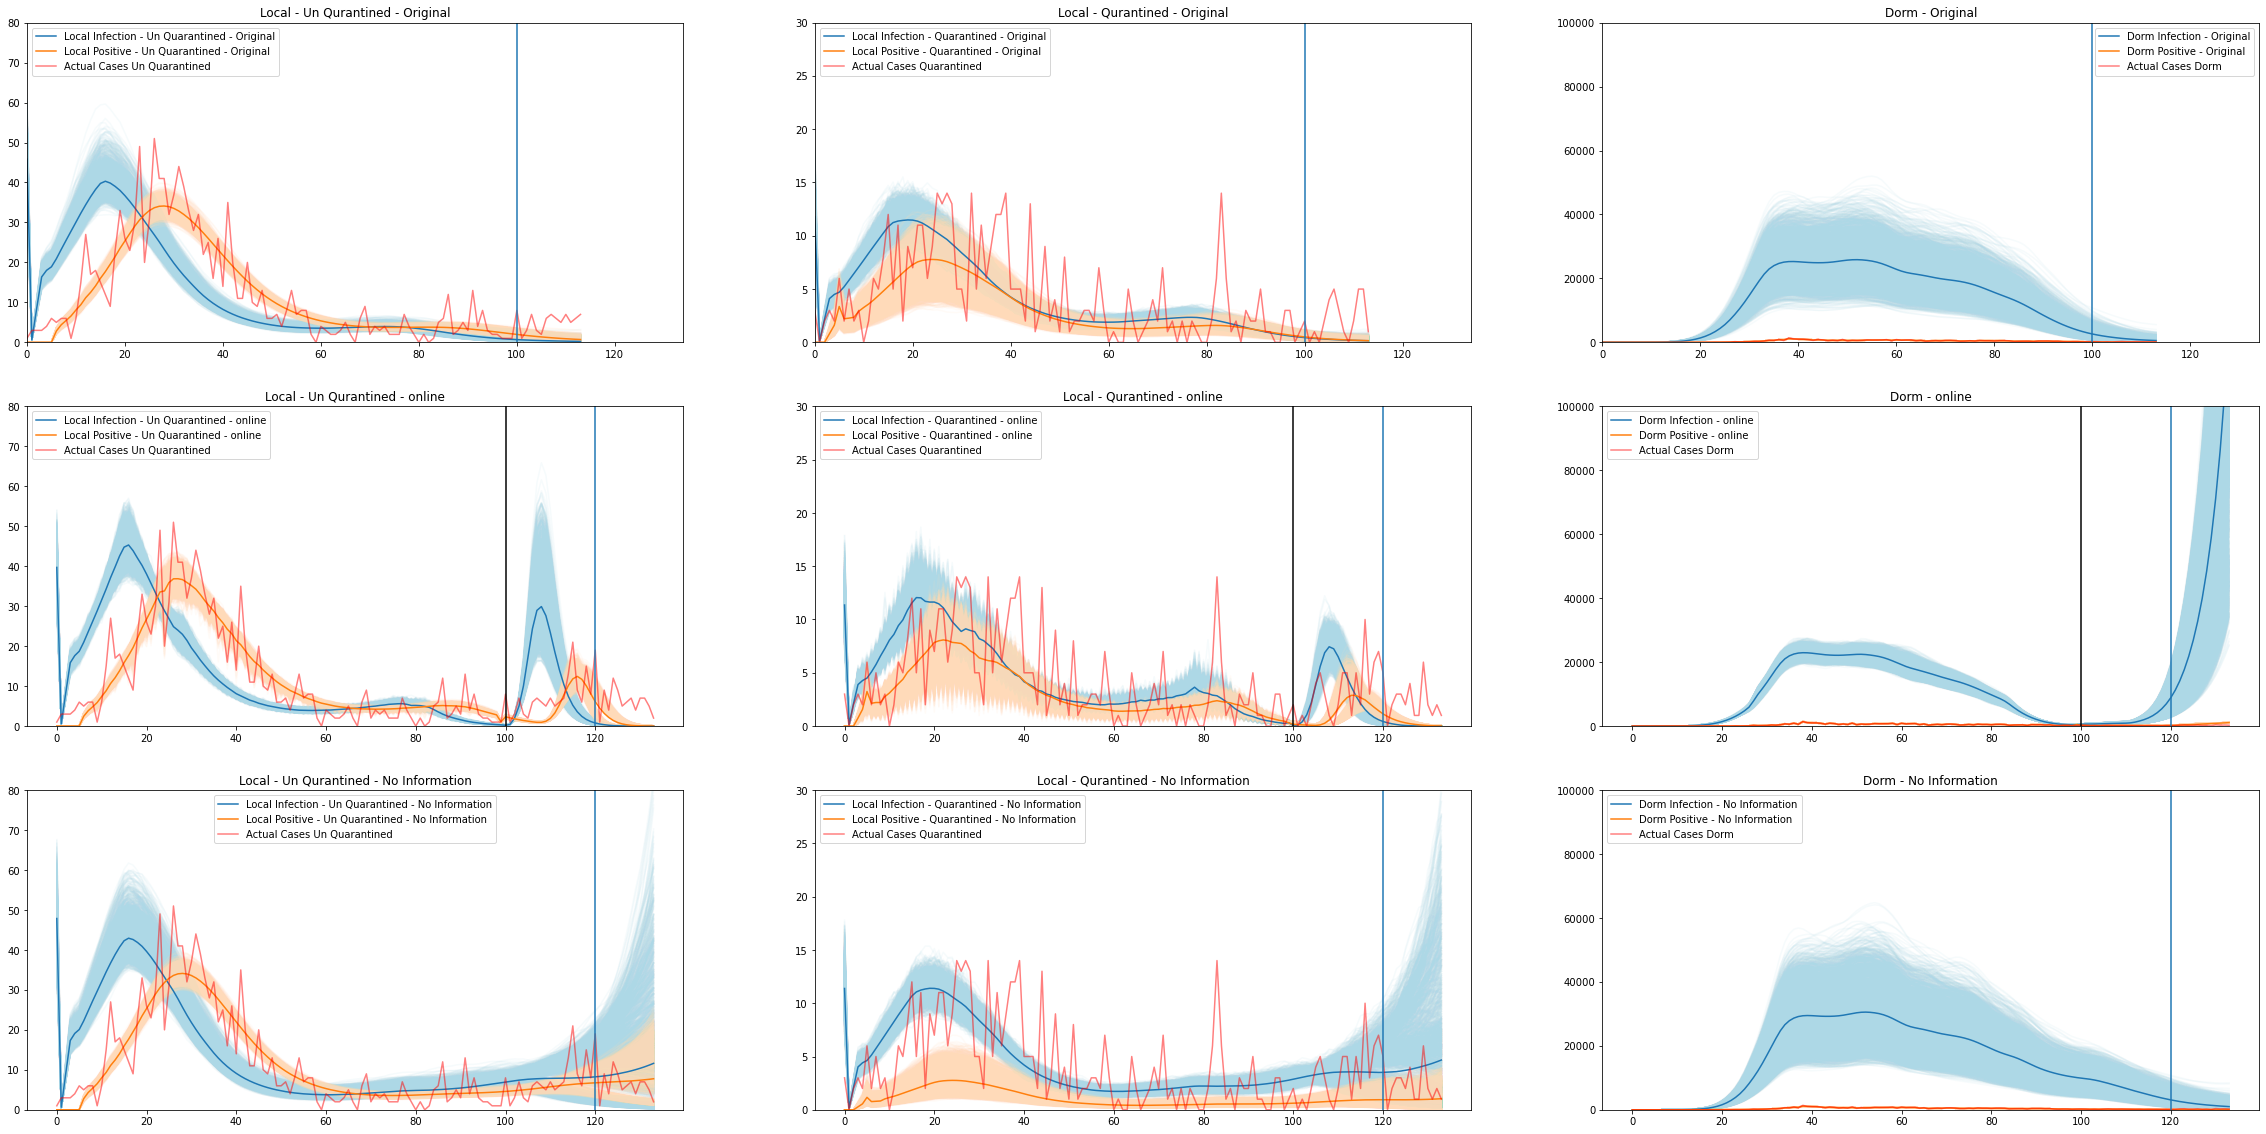

In [686]:
fig, ax = plt.subplots(3,3, figsize=(40,20))

row_nos = [0,1,2]
traces = [trace_prev, trace1, trace2]
desc_list = ['Original','online','No Information']
local_c_list = [all_cases_local1, all_cases_local2, all_cases_local2]
dorm_c_list = [all_dorm_cases1, all_dorm_cases2, all_dorm_cases2]
end_date_list = [100, 120, 120]
for r, trace_i, desc, local_c, dorm_c, ed in zip(row_nos, traces,
                                                 desc_list, local_c_list, dorm_c_list, end_date_list):
    # Un quarantined
    ax[r, 0].plot(trace_i['infections_local_uncontained'].T, c='lightblue', alpha=0.1)
    ax[r, 0].plot(trace_i['test_adjusted_positive_jit_local'].T, c='peachpuff', alpha=0.1)
    ax[r, 0].plot(trace_i['infections_local_uncontained'].mean(0), label=f'Local Infection - Un Quarantined - {desc}')
    ax[r, 0].plot(trace_i['test_adjusted_positive_jit_local'].mean(0), label=f'Local Positive - Un Quarantined - {desc}')
    ax[r, 0].set_ylim(0,80)
    # Quarantined
    ax[r, 1].plot(trace_i['infections_local_contained'].T, c='lightblue', alpha=0.1)
    ax[r, 1].plot(trace_i['test_adjusted_positive_jit_local_qurantined'].T, c='peachpuff', alpha=0.1)
    ax[r, 1].plot(trace_i['infections_local_contained'].mean(0), label=f'Local Infection - Quarantined - {desc}')
    ax[r, 1].plot(trace_i['test_adjusted_positive_jit_local_qurantined'].mean(0), label=f'Local Positive - Quarantined - {desc}')
    ax[r, 1].set_ylim(0,30)
    # Dorm
    ax[r, 2].plot(trace_i['infections_dorm'].T, c='lightblue', alpha=0.1)
    ax[r, 2].plot(trace_i['test_adjusted_positive_jit_dorm'].T, c='peachpuff', alpha=0.1)
    ax[r, 2].plot(trace_i['infections_dorm'].mean(0), label=f'Dorm Infection - {desc}')
    ax[r, 2].plot(trace_i['test_adjusted_positive_jit_dorm'].mean(0), label=f'Dorm Positive - {desc}')
    ax[r, 2].set_ylim(0, 100000)

    if (False) and (False):
        ax[r, 0].plot(np.concatenate([self.local_cases[0:self.end_date], actual_local_only]), c='r', alpha=0.5)
        ax[r, 1].plot(np.concatenate([self.dorm_cases[0:self.end_date], actual_dorm_only]), c='r', alpha=0.5)
    else:
        ax[r, 0].plot(local_c[0], c='r', alpha=0.5, label='Actual Cases Un Quarantined')
        ax[r, 1].plot(local_c[1], c='r', alpha=0.5, label='Actual Cases Quarantined')
        ax[r, 2].plot(dorm_c, c='r', alpha=0.5, label='Actual Cases Dorm')  

    #ax.plot(imported_input, c='g')

    ax[r, 0].axvline(x=ed)
    ax[r, 1].axvline(x=ed)
    ax[r, 2].axvline(x=ed)

    ax[r, 0].legend()
    ax[r, 1].legend()
    ax[r, 2].legend()

    ax[r, 0].set_title(f'Local - Un Qurantined - {desc}')
    ax[r, 1].set_title(f'Local - Qurantined - {desc}')
    ax[r, 2].set_title(f'Dorm - {desc}')
    
    if r == 0:
        ax[r, 0].set_xlim(0,120+14)
        ax[r, 1].set_xlim(0,120+14)
        ax[r, 2].set_xlim(0,120+14)
    
    if r==1:
        ax[r, 0].axvline(x=100, c='k')
        ax[r, 1].axvline(x=100, c='k')
        ax[r, 2].axvline(x=100, c='k')
plt.show()

RMSE Calc

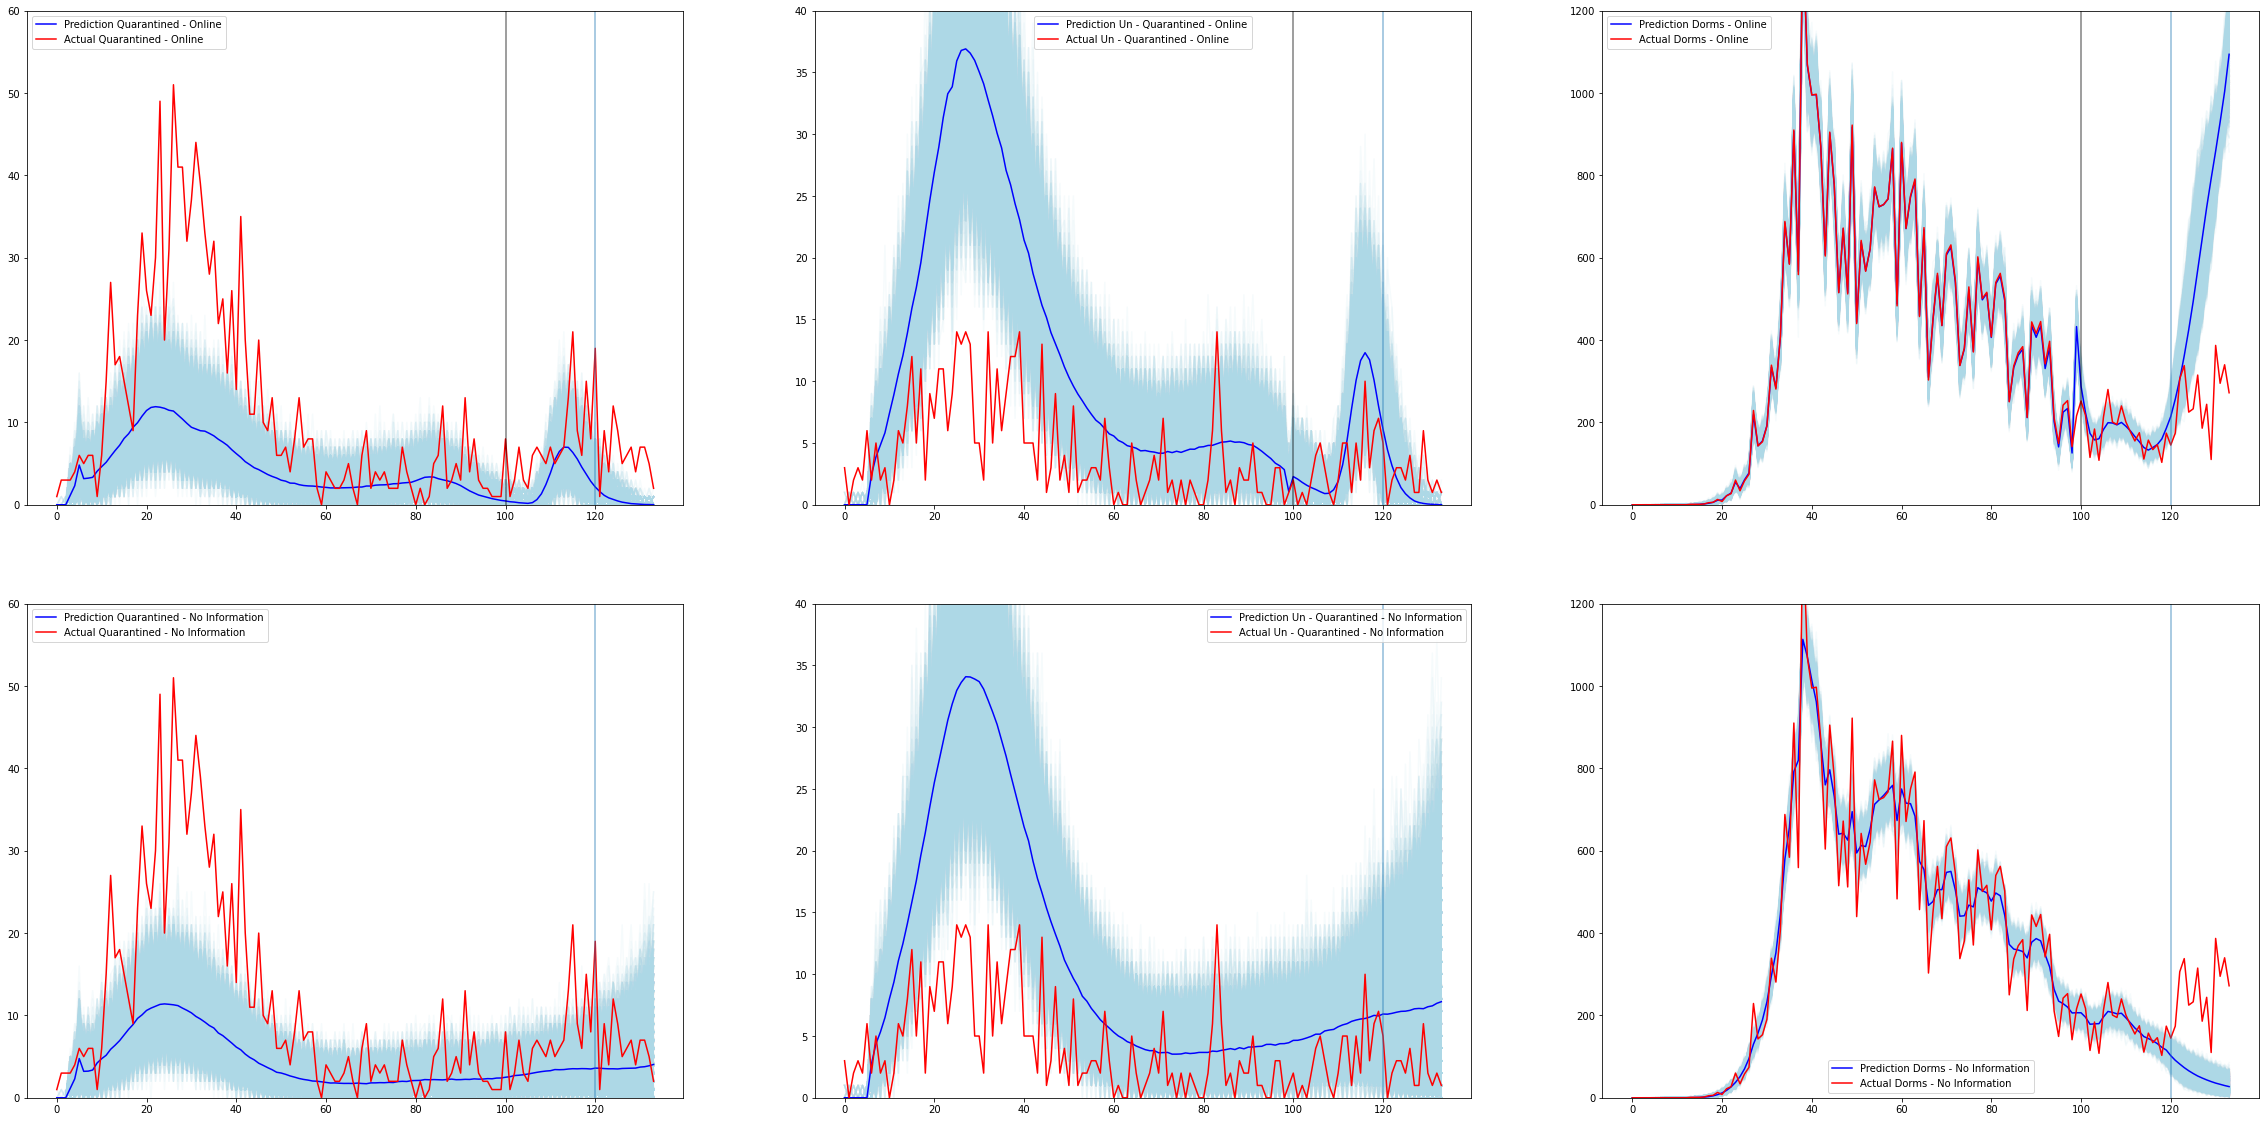

In [680]:
trace_list = [trace1, trace2]
trace_names = ['Online', 'No Info']
models = [model_new, model_unInf_prior]
train_time = 120
pred_t = 14
idx_list = [0, 1]
desc_list = ['Online', 'No Information']
fig, ax = plt.subplots(2,3, figsize=(40,20))

for tr, tr_name,mod,i, desc in zip(trace_list, trace_names, models, idx_list, desc_list):
    
    
    with mod:
        ppc_trace = pm.sample_posterior_predictive(tr)
    
    #### Quarantined Cases test - train    
    # Plot 
    ax[i,0].plot(ppc_trace['Obs_local_q'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,0].plot(ppc_trace['Obs_local_q'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Quarantined - {desc}')
    ax[i,0].plot(all_cases_local[0][0:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Quarantined - {desc}')
    
    #### Unquarantined Cases test - train
    # Plot 
    ax[i,1].plot(ppc_trace['Obs_local'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,1].plot(ppc_trace['Obs_local'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Un - Quarantined - {desc}')
    ax[i,1].plot(all_cases_local[1][0:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Un - Quarantined - {desc}')
    
    #### Dorm Cases test - train
    # Plot
    ax[i,2].plot(ppc_trace['Obs_dorm'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,2].plot(ppc_trace['Obs_dorm'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Dorms - {desc}')
    ax[i,2].plot(all_dorms[0:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Dorms - {desc}')
    
    ax[i, 0].legend()
    ax[i, 1].legend()
    ax[i, 2].legend()

    ax[i, 0].axvline(x=train_time, alpha=0.5)
    ax[i, 1].axvline(x=train_time, alpha=0.5)
    ax[i, 2].axvline(x=train_time, alpha=0.5)
    
    if desc == 'Online':
        ax[i, 0].axvline(x=100, alpha=0.5, c='k')
        ax[i, 1].axvline(x=100, alpha=0.5, c='k')
        ax[i, 2].axvline(x=100, alpha=0.5, c='k')
        
    ax[i, 0].set_ylim(0,60)
    ax[i, 1].set_ylim(0,40)
    ax[i, 2].set_ylim(0,1200)
    
plt.show()

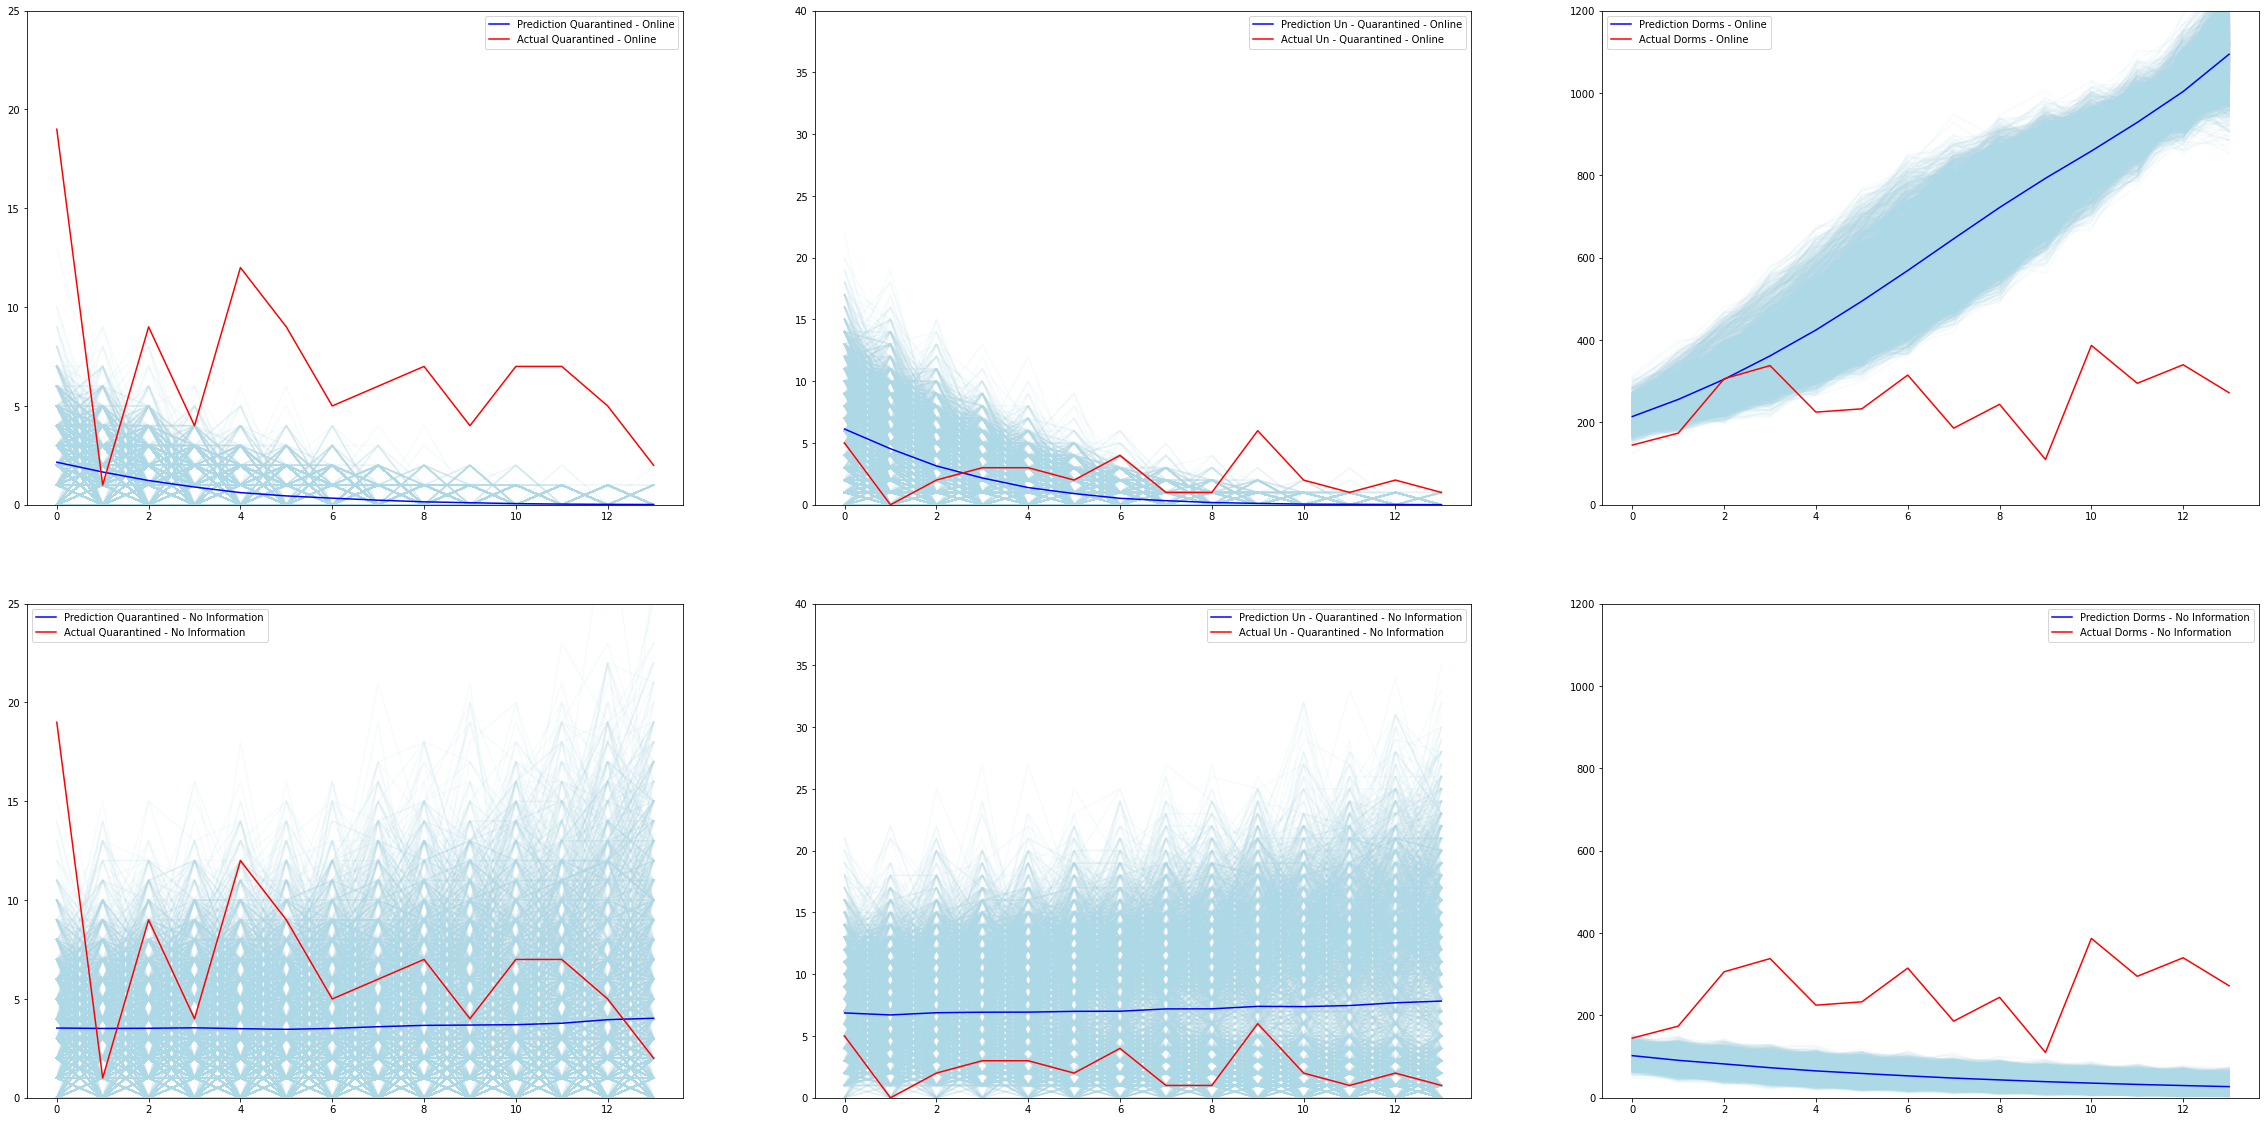

In [635]:
trace_list = [trace1, trace2]
trace_names = ['Online', 'No Info']
models = [model_new, model_unInf_prior]
train_time = 120
pred_t = 14
idx_list = [0, 1]
desc_list = ['Online', 'No Information']
fig, ax = plt.subplots(2,3, figsize=(40,20))

rmse_figs = {}

for tr, tr_name,mod,i, desc in zip(trace_list, trace_names, models, idx_list, desc_list):
    
    
    with mod:
        ppc_trace = pm.sample_posterior_predictive(tr)
    
    #### Quarantined Cases test - train
    Q_pred_mean_test = ppc_trace['Obs_local_q'].mean(0)[train_time:train_time+pred_t]
    Q_actual_test =  all_cases_local[0][train_time:train_time+pred_t]

    Q_pred_mean_train = ppc_trace['Obs_local_q'].mean(0)[0:train_time]
    Q_actual_train =  all_cases_local[0][0:train_time]
    
    # Plot 
    ax[i,0].plot(ppc_trace['Obs_local_q'][:,train_time:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,0].plot(ppc_trace['Obs_local_q'][:,train_time:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Quarantined - {desc}')
    ax[i,0].plot(all_cases_local[0][train_time:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Quarantined - {desc}')
    
    #### Unquarantined Cases test - train
    unQ_pred_mean_test = ppc_trace['Obs_local'].mean(0)[train_time:train_time+pred_t]
    unQ_actual_test = all_cases_local[1][train_time:train_time+pred_t]
    
    unQ_pred_mean_train = ppc_trace['Obs_local'].mean(0)[0:train_time]
    unQ_actual_train = all_cases_local[1][0:train_time]

     # Plot 
    ax[i,1].plot(ppc_trace['Obs_local'][:,train_time:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,1].plot(ppc_trace['Obs_local'][:,train_time:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Un - Quarantined - {desc}')
    ax[i,1].plot(all_cases_local[1][train_time:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Un - Quarantined - {desc}')
    
    #### Dorm Cases test - train
    dorm_pred_mean_test = ppc_trace['Obs_dorm'].mean(0)[train_time:train_time+pred_t]
    dorm_actual_test = all_dorms[train_time:train_time+pred_t]
    
    dorm_pred_mean_train = ppc_trace['Obs_dorm'].mean(0)[0:train_time]
    dorm_actual_train = all_dorms[0:train_time]
                 
    # Plot 
    ax[i,2].plot(ppc_trace['Obs_dorm'][:,train_time:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,2].plot(ppc_trace['Obs_dorm'][:,train_time:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Dorms - {desc}')
    ax[i,2].plot(all_dorms[train_time:train_time+pred_t].values, c='r',
                 alpha=1, label=f'Actual Dorms - {desc}')
    
    ax[i, 0].legend()
    ax[i, 1].legend()
    ax[i, 2].legend()
    
    ax[i, 0].set_ylim(0,25)
    ax[i, 1].set_ylim(0,40)
    ax[i, 2].set_ylim(0,1200)
    
    rmse_figs[desc] = {"Quarantined Train": Q_pred_mean_train - Q_actual_train,
                        "Quarantined Test": Q_pred_mean_test - Q_actual_test,
                       "UnQuarantined Train": unQ_pred_mean_train - unQ_actual_train,
                       "UnQuaratined Test": unQ_pred_mean_test - unQ_actual_test,
                       "Dorm Train": dorm_pred_mean_train - dorm_actual_train,
                       "Dorm Test": dorm_pred_mean_test - dorm_actual_test
                      }
    
plt.show()

#### Residual Plots

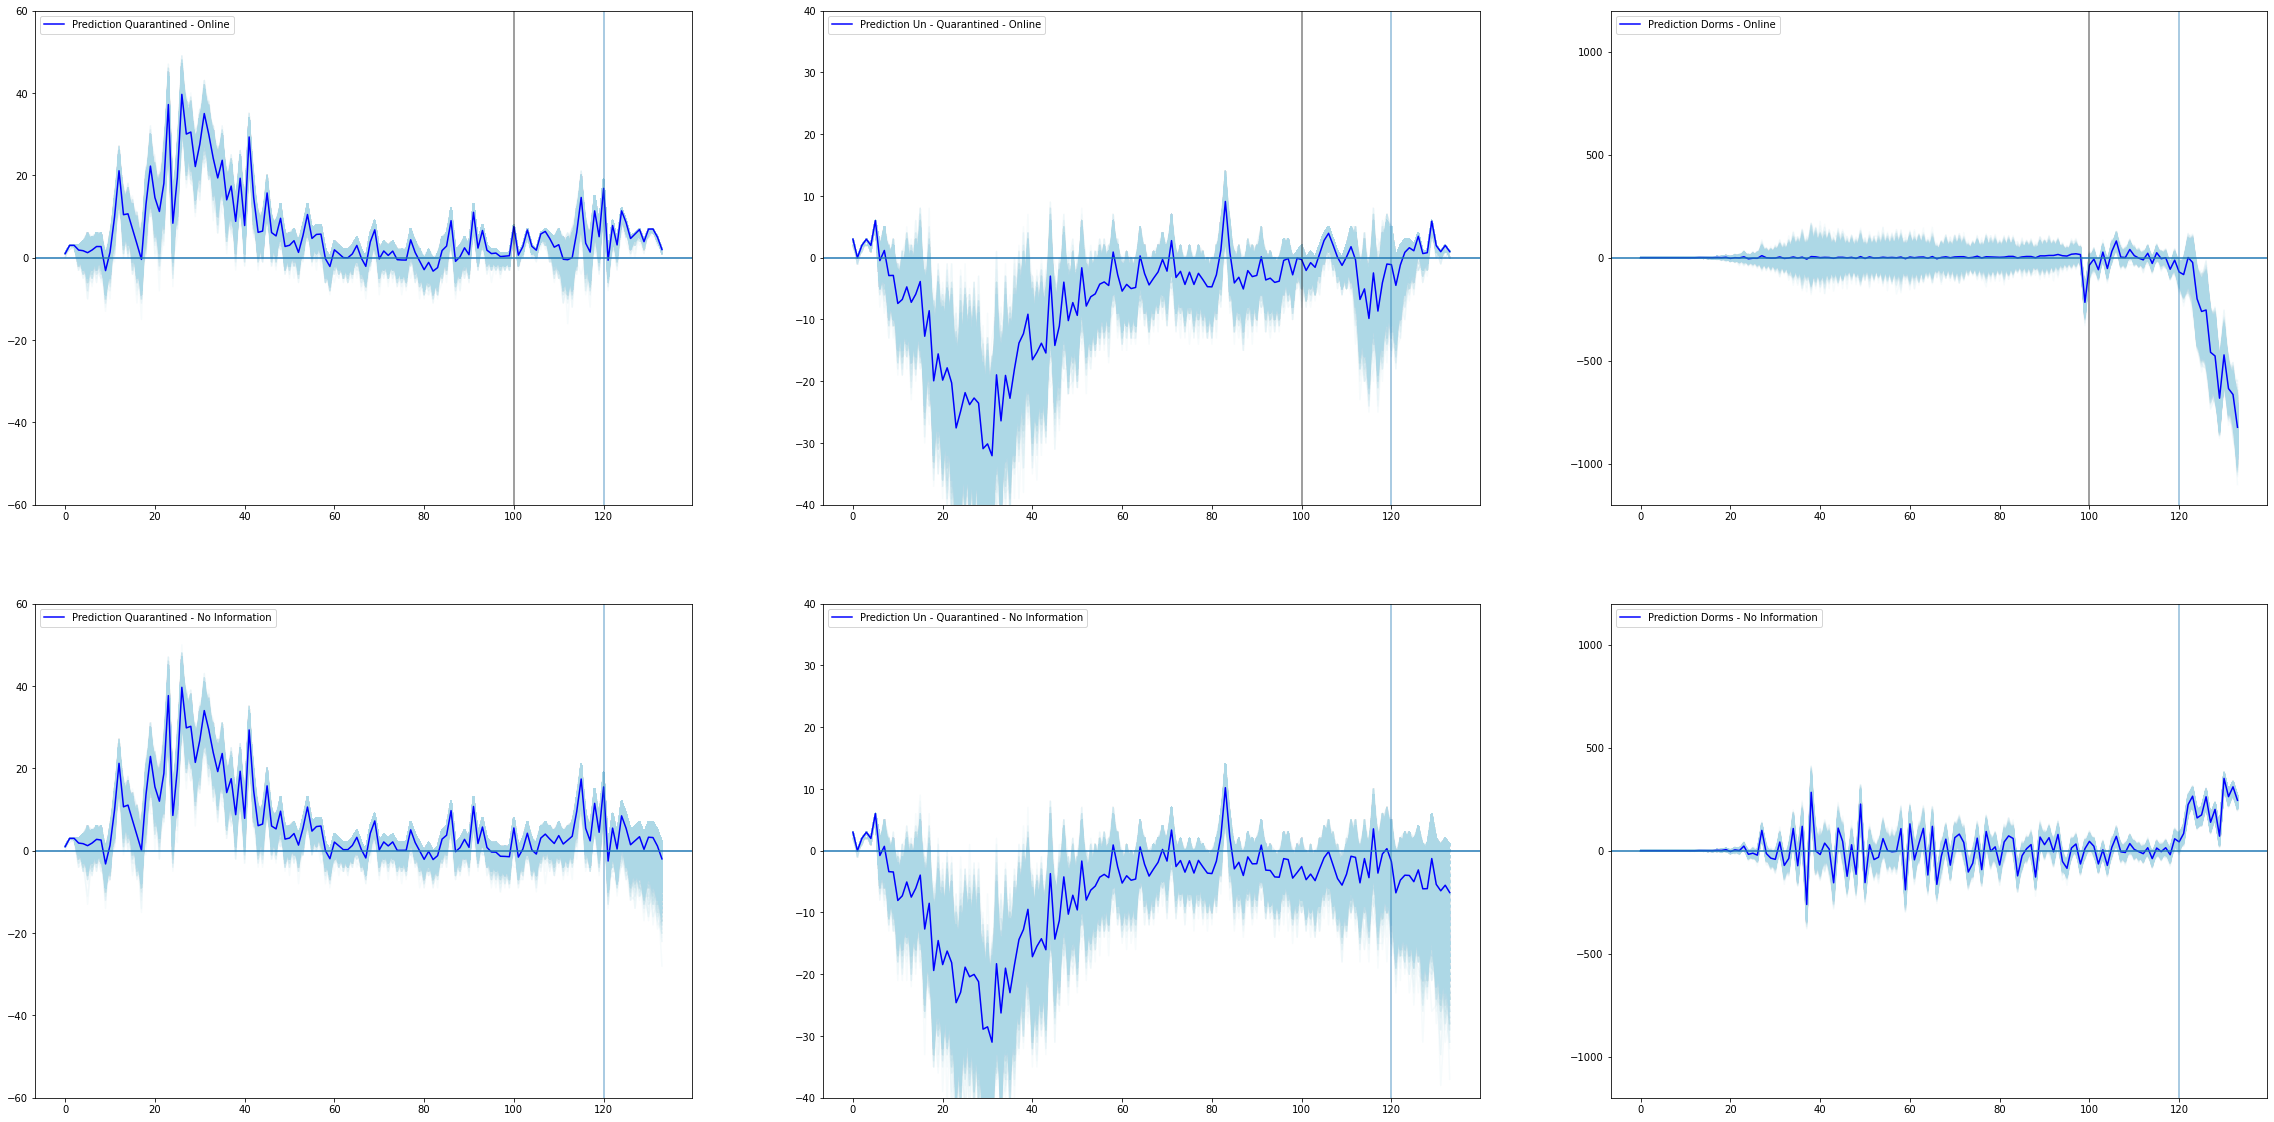

In [681]:
trace_list = [trace1, trace2]
trace_names = ['Online', 'No Info']
models = [model_new, model_unInf_prior]
train_time = 120
pred_t = 14
idx_list = [0, 1]
desc_list = ['Online', 'No Information']
fig, ax = plt.subplots(2,3, figsize=(40,20))
num_samps = 3000

for tr, tr_name,mod,i, desc in zip(trace_list, trace_names, models, idx_list, desc_list):
    
    
    with mod:
        ppc_trace = pm.sample_posterior_predictive(tr)
    
    #### Quarantined Cases test - train    
    # Plot 
    ax[i,0].plot(np.tile(all_cases_local[0][0:train_time+pred_t].values, (num_samps,1)).T - ppc_trace['Obs_local_q'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,0].plot(all_cases_local[0][0:train_time+pred_t].values - ppc_trace['Obs_local_q'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Quarantined - {desc}')
    
    #### Unquarantined Cases test - train
    # Plot 
    ax[i,1].plot(np.tile(all_cases_local[1][0:train_time+pred_t].values, (num_samps,1)).T - ppc_trace['Obs_local'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,1].plot(all_cases_local[1][0:train_time+pred_t].values - ppc_trace['Obs_local'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Un - Quarantined - {desc}')

    #### Dorm Cases test - train
    # Plot
    ax[i,2].plot(np.tile(all_dorms[0:train_time+pred_t].values, (num_samps,1)).T - ppc_trace['Obs_dorm'][:,0:train_time+pred_t].T, c='lightblue', alpha=0.1)
    ax[i,2].plot(all_dorms[0:train_time+pred_t].values - ppc_trace['Obs_dorm'][:,0:train_time+pred_t].mean(0),
                 c='b', alpha=1, label=f'Prediction Dorms - {desc}')

    
    ax[i, 0].legend()
    ax[i, 1].legend()
    ax[i, 2].legend()

    ax[i, 0].axvline(x=train_time, alpha=0.5)
    ax[i, 1].axvline(x=train_time, alpha=0.5)
    ax[i, 2].axvline(x=train_time, alpha=0.5)

    if desc == 'Online':
        ax[i, 0].axvline(x=100, alpha=0.5, c='k')
        ax[i, 1].axvline(x=100, alpha=0.5, c='k')
        ax[i, 2].axvline(x=100, alpha=0.5, c='k')
        
    ax[i, 0].axhline(y=0, alpha=1)
    ax[i, 1].axhline(y=0, alpha=1)
    ax[i, 2].axhline(y=0, alpha=1)
    
    
    ax[i, 0].set_ylim(-60,60)
    ax[i, 1].set_ylim(-40,40)
    ax[i, 2].set_ylim(-1200,1200)
    
plt.show()

RMSE

In [636]:
rmse_table = {}
for desc in rmse_figs.keys():
    rmse_table[desc] = {}
    for k in rmse_figs[desc].keys():
        rmse_table[desc][k] = np.sqrt(np.mean((rmse_figs[desc][k]**2)))
        

In [648]:
pd.DataFrame.from_dict(rmse_table)

,Online,No Information
Quarantined Train,11.631001,11.644801
Quarantined Test,7.556948,5.507043
UnQuarantined Train,10.770397,10.249734
UnQuaratined Test,2.465139,5.112117
Dorm Train,24.514571,73.518626
Dorm Test,449.689199,218.122972


### Fit Statistics on Coefficients Variables
- Betas

In [711]:
445000*60*60*5

8010000000